In [1]:
import numpy as np
from collections import Counter


def log_deformed_gaussian(x, mu, var):
    norm_squared = ((x - mu) * (x - mu)).sum(axis=1)
    return -norm_squared / (2 * var)


class ClusterArray(object):
    def __init__(self, array):
        # arrayは1次元のリスト、配列
        self._array = np.array(array, dtype=np.int)
        self._counter = Counter(array)

    @property
    def array(self):
        return self._array.copy()

    def count(self, k):
        return self._counter[k]

    def __setitem__(self, i, k):
        # 実行されるとself._counterも更新される
        pre_value = self._array[i]
        if pre_value == k:
            return

        if self._counter[pre_value] > 0:
            self._counter[pre_value] -= 1
        self._array[i] = k
        self._counter[k] += 1

    def __getitem__(self, i):
        return self._array[i]


class GaussianMixtureClustering(object):
    def __init__(self, K, D, var=1, var_pri=1, seed=None):
        self.K = K  # クラスタ数
        self.D = D  # 説明変数の次元(実装しやすたのため、コンストラクタの時点で設定しておく)
        self.z = None

        # 確率分布のパラメータ設定
        self.mu = np.zeros((self.K, self.D))
        self.var = var  # 固定、すべてのクラスタで共通
        self.pi = np.full(self.K, 1 / self.K)  # 固定、すべてのクラスタで共通

        # 事前分布の設定
        self.mu_pri = np.zeros(self.D)
        self.var_pri = var_pri

        self._random = np.random.RandomState(seed)

    def fit(self, X, n_iter):
        init_z = self._random.randint(0, self.K, X.shape[0])
        self.z = ClusterArray(init_z)

        for _ in range(n_iter):
            for k in range(self.K):
                self.mu[k] = self._sample_mu_k(X, k)
            for i, x_i in enumerate(X):
                self.z[i] = self._sample_zi(x_i)

    def _sample_zi(self, x_i):
        log_probs_xi = log_deformed_gaussian(x_i, self.mu, self.var)

        probs_zi = np.exp(log_probs_xi) * self.pi
        probs_zi = probs_zi / probs_zi.sum()

        z_i = self._random.multinomial(1, probs_zi)
        z_i = np.where(z_i)[0][0]
        return z_i

    def _sample_mu_k(self, X, k):
        xk_bar = np.array([x for i, x in enumerate(X) if self.z[i] == k]).mean(axis=0)
        var_pos = 1 / (self.z.count(k) / self.var + 1 / self.var_pri)
        mu_pos = var_pos * (xk_bar * self.z.count(k) / self.var + self.mu_pri / self.var_pri)

        mu_k = self._random.multivariate_normal(mu_pos, var_pos * np.eye(self.D))
        return mu_k

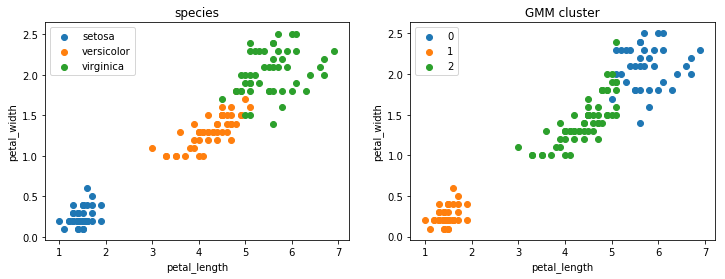

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# データセットの読み込み
df = sns.load_dataset('iris')
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

# 混合ガウスモデルによるクラスタリング
gmc = GaussianMixtureClustering(K=3, D=4, var=0.1, seed=1)
gmc.fit(X, n_iter=10)
df['GMM_cluster'] = gmc.z.array

# 結果の可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for sp in df['species'].unique():
    x = df[df['species'] == sp]['petal_length']
    y = df[df['species'] == sp]['petal_width']
    ax1.scatter(x, y, label=sp)
ax1.legend()
ax1.set_title('species')
ax1.set_xlabel('petal_length')
ax1.set_ylabel('petal_width')
for k in range(gmc.K):
    x = df[df['GMM_cluster'] == k]['petal_length']
    y = df[df['GMM_cluster'] == k]['petal_width']
    ax2.scatter(x, y, label=k)
ax2.legend()
ax2.set_title('GMM cluster')
ax2.set_xlabel('petal_length')
ax2.set_ylabel('petal_width')
plt.show()